# Geometry Analysis with abagpdb

This notebook demonstrates how to **analyze protein geometry** including backbone torsion angles, sidechain rotamers, and structural features using the `abagpdb` package.

## Overview

Geometry analysis helps you:
- **Backbone dihedrals (φ, ψ, ω)**: Main chain torsion angles
- **Sidechain chi angles (χ1-χ4)**: Side chain rotamer conformations
- **CA bend angles**: Backbone curvature and kinks
- **Ramachandran analysis**: Identify unusual conformations
- **Structural validation**: Quality assessment

## Key Angles

| Angle | Definition | Description |
|-------|------------|-------------|
| **φ (phi)** | C(i-1) - N(i) - CA(i) - C(i) | Rotation around N-CA bond |
| **ψ (psi)** | N(i) - CA(i) - C(i) - N(i+1) | Rotation around CA-C bond |
| **ω (omega)** | CA(i) - C(i) - N(i+1) - CA(i+1) | Peptide bond planarity (~180° trans, ~0° cis) |
| **χ (chi)** | Various | Sidechain rotations |

---

## Example: Antibody-Antigen Complex (PDB: 5GGS)

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from abagpdb.pdbparser import parse_pdb
from abagpdb.geometry import (
    compute_backbone_angles,
    compute_sidechain_chis,
    compute_ca_bend_angles,
    analyze_geometry
)

## 2. Load PDB Structure

In [2]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("✓ Structure loaded successfully!")
print(f"  File: {cx.source_path}")
print(f"  Chains: {', '.join(cx.chains.keys())}")

# Count residues
total_residues = sum(len(chain.residues) for chain in cx.chains.values())
print(f"  Total residues: {total_residues}")

✓ Structure loaded successfully!
  File: 5GGS_wt.pdb
  Chains: A, H, L
  Total residues: 549


## 3. Backbone Dihedral Angles (φ, ψ, ω)

Calculate the main chain torsion angles for all residues.

In [3]:
# Compute backbone angles for all chains
backbone_angles = compute_backbone_angles(cx, list(cx.chains.keys()))

print("="* 80)
print("BACKBONE ANGLE COMPUTATION COMPLETE".center(80))
print("=" * 80)
print(f"Total residues analyzed: {len(backbone_angles)}")
print(f"Residues with valid φ:   {sum(1 for ba in backbone_angles if ba.phi is not None)}")
print(f"Residues with valid ψ:   {sum(1 for ba in backbone_angles if ba.psi is not None)}")
print(f"Residues with valid ω:   {sum(1 for ba in backbone_angles if ba.omega is not None)}")
print("=" * 80)

                      BACKBONE ANGLE COMPUTATION COMPLETE                       
Total residues analyzed: 549
Residues with valid φ:   546
Residues with valid ψ:   546
Residues with valid ω:   546


### Sample Backbone Angles

Display angles for first 10 residues.

In [4]:
# Display sample angles
print("=" * 90)
print("SAMPLE BACKBONE ANGLES (First 10 residues with all angles)".center(90))
print("=" * 90)
print(f"{'Residue':<20}{'φ (phi)':<15}{'ψ (psi)':<15}{'ω (omega)':<15}{'Region':<20}")
print("-" * 90)

count = 0
for ba in backbone_angles:
    if ba.phi is not None and ba.psi is not None and ba.omega is not None:
        # Classify secondary structure region (simplified)
        if -180 <= ba.phi <= -30 and -180 <= ba.psi <= 45:
            region = "β-sheet region"
        elif -90 <= ba.phi <= -30 and -75 <= ba.psi <= -15:
            region = "α-helix region"
        else:
            region = "Other"
        
        print(f"{ba.residue_id:<20}{ba.phi:<15.1f}{ba.psi:<15.1f}{ba.omega:<15.1f}{region:<20}")
        count += 1
        if count >= 10:
            break

print("=" * 90)

                SAMPLE BACKBONE ANGLES (First 10 residues with all angles)                
Residue             φ (phi)        ψ (psi)        ω (omega)      Region              
------------------------------------------------------------------------------------------
TRP A:2             -163.0         153.0          -176.4         Other               
ASN A:3             -108.4         160.8          177.1          Other               
PRO A:4             -67.3          150.3          178.4          Other               
PRO A:5             -68.8          161.6          172.7          Other               
THR A:6             -101.2         154.9          -171.7         Other               
PHE A:7             -142.4         114.1          -173.3         Other               
SER A:8             -136.8         158.9          -2.9           Other               
PRO A:9             -77.0          160.2          177.9          Other               
ALA A:10            -60.8          -35.4    

### Ramachandran Plot

Visualize φ-ψ distribution to assess backbone geometry.

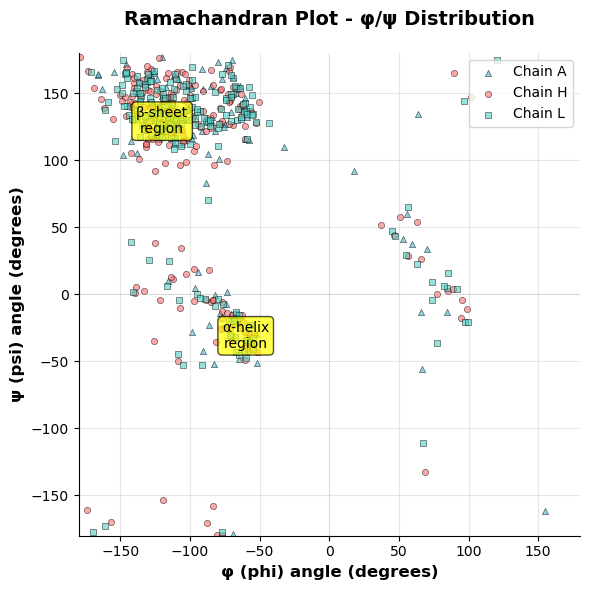

Total φ-ψ pairs plotted: 543


In [10]:
# Extract phi-psi pairs
phi_psi_pairs = [(ba.phi, ba.psi) for ba in backbone_angles 
                 if ba.phi is not None and ba.psi is not None]

phi_vals = [pair[0] for pair in phi_psi_pairs]
psi_vals = [pair[1] for pair in phi_psi_pairs]

# Separate by chain for coloring
chains_data = {}
for ba in backbone_angles:
    if ba.phi is not None and ba.psi is not None:
        if ba.chain_id not in chains_data:
            chains_data[ba.chain_id] = {'phi': [], 'psi': []}
        chains_data[ba.chain_id]['phi'].append(ba.phi)
        chains_data[ba.chain_id]['psi'].append(ba.psi)

# Create Ramachandran plot
fig, ax = plt.subplots(figsize=(6, 6))

colors = {'H': '#FF6B6B', 'L': '#4ECDC4', 'A': '#45B7D1'}
markers = {'H': 'o', 'L': 's', 'A': '^'}

for chain_id, data in chains_data.items():
    ax.scatter(data['phi'], data['psi'], 
              c=colors.get(chain_id, '#95A5A6'), 
              marker=markers.get(chain_id, 'o'),
              s=20, alpha=0.6, edgecolors='black', linewidth=0.5,
              label=f'Chain {chain_id}')

# Add region labels
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# Label key regions
ax.text(-60, -40, 'α-helix\nregion', fontsize=10, ha='center', 
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
ax.text(-120, 120, 'β-sheet\nregion', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax.set_xlabel('φ (phi) angle (degrees)', fontweight='bold', fontsize=12)
ax.set_ylabel('ψ (psi) angle (degrees)', fontweight='bold', fontsize=12)
ax.set_title('Ramachandran Plot - φ/ψ Distribution', fontweight='bold', fontsize=14, pad=20)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Total φ-ψ pairs plotted: {len(phi_psi_pairs)}")

### Omega Angle Distribution

Check peptide bond planarity (should be ~180° for trans, ~0° for cis).

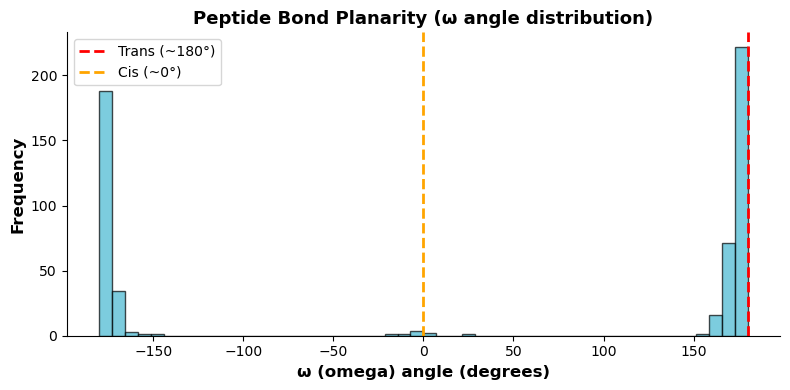


Omega Angle Statistics:
  Mean:   26.07°
  Median: 169.37°
  Std:    171.83°
  Range:  [-179.95°, 180.00°]

Cis peptide bonds found: 9
  • PRO A:1: ω = -20.5°
  • SER A:8: ω = -2.9°
  • SER A:30: ω = 21.9°
  • PHE A:52: ω = -5.0°
  • PHE H:152: ω = -6.5°


In [12]:
# Analyze omega angles
omega_vals = [ba.omega for ba in backbone_angles if ba.omega is not None]

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(omega_vals, bins=50, color='#45B7D1', edgecolor='black', alpha=0.7)
ax.axvline(180, color='red', linestyle='--', linewidth=2, label='Trans (~180°)')
ax.axvline(0, color='orange', linestyle='--', linewidth=2, label='Cis (~0°)')

ax.set_xlabel('ω (omega) angle (degrees)', fontweight='bold', fontsize=12)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Peptide Bond Planarity (ω angle distribution)', fontweight='bold', fontsize=13)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Statistics
print("\nOmega Angle Statistics:")
print(f"  Mean:   {np.mean(omega_vals):.2f}°")
print(f"  Median: {np.median(omega_vals):.2f}°")
print(f"  Std:    {np.std(omega_vals):.2f}°")
print(f"  Range:  [{min(omega_vals):.2f}°, {max(omega_vals):.2f}°]")

# Check for cis peptides (|omega| < 30°)
cis_peptides = [ba for ba in backbone_angles if ba.omega is not None and abs(ba.omega) < 30]
print(f"\nCis peptide bonds found: {len(cis_peptides)}")
if cis_peptides:
    for ba in cis_peptides[:5]:  # Show first 5
        print(f"  • {ba.residue_id}: ω = {ba.omega:.1f}°")

## 4. Sidechain Chi Angles (χ1-χ4)

Analyze sidechain rotamer conformations.

In [13]:
# Compute sidechain chi angles
sidechain_chis = compute_sidechain_chis(cx, list(cx.chains.keys()))

print("=" * 80)
print("SIDECHAIN CHI ANGLE COMPUTATION COMPLETE".center(80))
print("=" * 80)
print(f"Total residues with chi angles: {len(sidechain_chis)}")

# Count by number of chi angles
chi_counts = Counter(sc.num_chis for sc in sidechain_chis)
print(f"\nDistribution by number of chi angles:")
for num_chis, count in sorted(chi_counts.items()):
    print(f"  χ1-χ{num_chis}: {count} residues")

print("=" * 80)

                    SIDECHAIN CHI ANGLE COMPUTATION COMPLETE                    
Total residues with chi angles: 474

Distribution by number of chi angles:
  χ1-χ1: 175 residues
  χ1-χ2: 193 residues
  χ1-χ3: 54 residues
  χ1-χ4: 52 residues


### Sample Chi Angles

Display chi angles for selected residues.

In [14]:
# Show chi angles for residues with 3-4 chis (longest sidechains)
long_sidechains = [sc for sc in sidechain_chis if sc.num_chis >= 3]

print("=" * 100)
print("SAMPLE CHI ANGLES (Residues with 3-4 chi angles)".center(100))
print("=" * 100)
print(f"{'Residue':<20}{'Type':<10}{'χ1':<15}{'χ2':<15}{'χ3':<15}{'χ4':<15}")
print("-" * 100)

for sc in long_sidechains[:15]:  # Show first 15
    chi1 = f"{sc.chis.get('chi1'):.1f}" if sc.chis.get('chi1') is not None else "—"
    chi2 = f"{sc.chis.get('chi2'):.1f}" if sc.chis.get('chi2') is not None else "—"
    chi3 = f"{sc.chis.get('chi3'):.1f}" if sc.chis.get('chi3') is not None else "—"
    chi4 = f"{sc.chis.get('chi4'):.1f}" if sc.chis.get('chi4') is not None else "—"
    
    print(f"{sc.residue_id:<20}{sc.resname:<10}{chi1:<15}{chi2:<15}{chi3:<15}{chi4:<15}")

print("=" * 100)

                          SAMPLE CHI ANGLES (Residues with 3-4 chi angles)                          
Residue             Type      χ1             χ2             χ3             χ4             
----------------------------------------------------------------------------------------------------
GLU A:16            GLU       -176.3         -82.5          -25.0          —              
GLU A:31            GLU       -29.3          -158.5         27.0           —              
ARG A:39            ARG       168.3          -178.9         176.4          -176.1         
MET A:40            MET       -65.6          -52.0          -63.7          —              
GLN A:45            GLN       -60.3          -74.0          -15.2          —              
LYS A:48            LYS       172.0          151.6          134.7          -66.8          
GLU A:54            GLU       -160.2         178.7          20.7           —              
ARG A:56            ARG       -61.6          -172.2         -172.6    

### Chi1 Distribution by Residue Type

Analyze the most common χ1 angles for different amino acids.

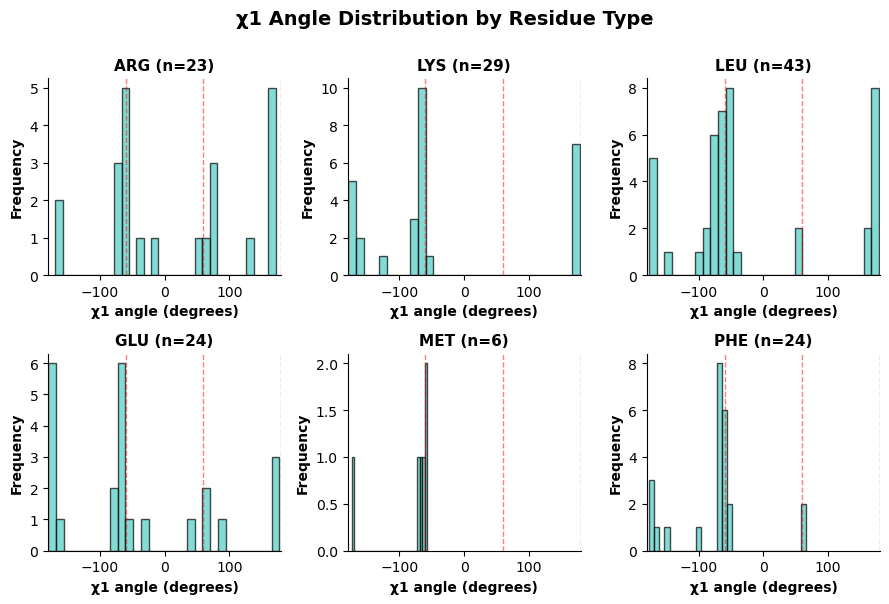

In [20]:
# Group chi1 angles by residue type
residue_types = ['ARG', 'LYS', 'LEU', 'GLU', 'MET', 'PHE']  # Common residues

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

for idx, restype in enumerate(residue_types):
    ax = axes[idx]
    
    # Get chi1 values for this residue type
    chi1_vals = [sc.chis.get('chi1') for sc in sidechain_chis 
                 if sc.resname == restype and sc.chis.get('chi1') is not None]
    
    if chi1_vals:
        ax.hist(chi1_vals, bins=30, color='#4ECDC4', edgecolor='black', alpha=0.7)
        ax.axvline(-60, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.axvline(60, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.axvline(180, color='red', linestyle='--', alpha=0.5, linewidth=1)
        
        ax.set_xlabel('χ1 angle (degrees)', fontweight='bold', fontsize=10)
        ax.set_ylabel('Frequency', fontweight='bold', fontsize=10)
        ax.set_title(f'{restype} (n={len(chi1_vals)})', fontweight='bold', fontsize=11)
        ax.set_xlim(-180, 180)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.suptitle('χ1 Angle Distribution by Residue Type', 
             fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 5. CA Bend Angles

Analyze backbone curvature using CA-CA-CA angles.

In [16]:
# Compute CA bend angles
bend_angles = compute_ca_bend_angles(cx, list(cx.chains.keys()))

print("=" * 80)
print("CA BEND ANGLE COMPUTATION COMPLETE".center(80))
print("=" * 80)
print(f"Total residues analyzed: {len(bend_angles)}")

valid_bends = [ba for ba in bend_angles if ba.angle_deg is not None]
print(f"Valid bend angles:       {len(valid_bends)}")

if valid_bends:
    angles = [ba.angle_deg for ba in valid_bends]
    print(f"\nBend Angle Statistics:")
    print(f"  Mean:   {np.mean(angles):.2f}°")
    print(f"  Median: {np.median(angles):.2f}°")
    print(f"  Range:  [{min(angles):.2f}°, {max(angles):.2f}°]")

print("=" * 80)

                       CA BEND ANGLE COMPUTATION COMPLETE                       
Total residues analyzed: 549
Valid bend angles:       543

Bend Angle Statistics:
  Mean:   116.28°
  Median: 118.60°
  Range:  [72.40°, 164.63°]


### Bend Angle Distribution

Visualize backbone curvature. Angles close to 180° indicate straight/extended regions.

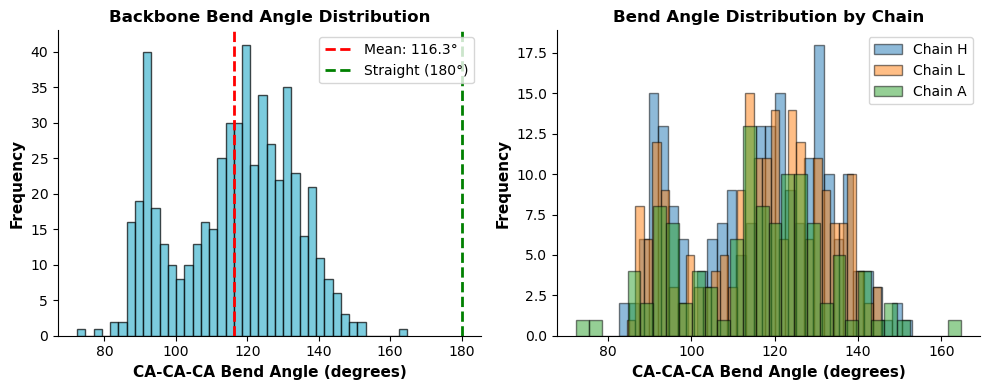

In [18]:
# Plot bend angle distribution
angles = [ba.angle_deg for ba in bend_angles if ba.angle_deg is not None]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
ax1.hist(angles, bins=40, color='#45B7D1', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(angles), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(angles):.1f}°')
ax1.axvline(180, color='green', linestyle='--', linewidth=2, 
            label='Straight (180°)')
ax1.set_xlabel('CA-CA-CA Bend Angle (degrees)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax1.set_title('Backbone Bend Angle Distribution', fontweight='bold', fontsize=12)
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Separate by chain
for chain_id in ['H', 'L', 'A']:
    chain_angles = [ba.angle_deg for ba in bend_angles 
                   if ba.chain_id == chain_id and ba.angle_deg is not None]
    if chain_angles:
        ax2.hist(chain_angles, bins=30, alpha=0.5, label=f'Chain {chain_id}',
                edgecolor='black')

ax2.set_xlabel('CA-CA-CA Bend Angle (degrees)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax2.set_title('Bend Angle Distribution by Chain', fontweight='bold', fontsize=12)
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Identify Sharp Bends/Kinks

Find regions with significant backbone curvature (angle < 140°).

In [21]:
# Find sharp bends
sharp_bends = [ba for ba in bend_angles if ba.is_bent]

print("=" * 70)
print(f"SHARP BENDS/KINKS (angle < 140°)".center(70))
print("=" * 70)
print(f"Total sharp bends found: {len(sharp_bends)}")

if sharp_bends:
    # Sort by angle (sharpest first)
    sharp_bends_sorted = sorted(sharp_bends, key=lambda x: x.angle_deg)
    
    print(f"\nTop 10 sharpest bends:")
    print(f"{'Rank':<6}{'Residue':<20}{'Chain':<8}{'Angle':<12}{'Classification':<20}")
    print("-" * 70)
    
    for i, ba in enumerate(sharp_bends_sorted[:10], 1):
        if ba.angle_deg < 100:
            classification = "Very sharp"
        elif ba.angle_deg < 120:
            classification = "Sharp"
        else:
            classification = "Moderate bend"
        
        print(f"{i:<6}{ba.residue_id:<20}{ba.chain_id:<8}{ba.angle_deg:<12.1f}{classification:<20}")

print("=" * 70)

                   SHARP BENDS/KINKS (angle < 140°)                   
Total sharp bends found: 512

Top 10 sharpest bends:
Rank  Residue             Chain   Angle       Classification      
----------------------------------------------------------------------
1     GLU A:31            A       72.4        Very sharp          
2     PRO A:100           A       77.8        Very sharp          
3     ASP H:89            H       82.7        Very sharp          
4     SER H:119           H       83.5        Very sharp          
5     ASP L:155           L       84.5        Very sharp          
6     ASN A:72            A       85.0        Very sharp          
7     SER H:134           H       86.3        Very sharp          
8     PRO A:42            A       86.4        Very sharp          
9     SER H:178           H       86.8        Very sharp          
10    ASP L:126           L       86.9        Very sharp          


## 6. Comprehensive Analysis

Use the all-in-one function for complete geometry analysis.

In [22]:
# Perform comprehensive analysis on heavy chain
geom_analysis = analyze_geometry(
    cx=cx,
    selection=["H"],  # Analyze heavy chain
    compute_backbone=True,
    compute_sidechains=True,
    compute_bends=True
)

print("✓ Comprehensive geometry analysis complete for chain H!")
print(f"  Backbone angles:  {len(geom_analysis.backbone) if geom_analysis.backbone else 0} residues")
print(f"  Sidechain chis:   {len(geom_analysis.sidechains) if geom_analysis.sidechains else 0} residues")
print(f"  Bend angles:      {len(geom_analysis.bends) if geom_analysis.bends else 0} residues")

✓ Comprehensive geometry analysis complete for chain H!
  Backbone angles:  219 residues
  Sidechain chis:   187 residues
  Bend angles:      219 residues


## 7. Export to DataFrames

Convert geometry data to pandas DataFrames for analysis.

In [23]:
# Convert to DataFrames
df_backbone = geom_analysis.to_dataframe("backbone")
df_sidechains = geom_analysis.to_dataframe("sidechains")
df_bends = geom_analysis.to_dataframe("bends")

print("DataFrames created successfully!")
print(f"\nBackbone DataFrame: {df_backbone.shape[0]} rows × {df_backbone.shape[1]} columns")
print(f"Columns: {list(df_backbone.columns)}")

print(f"\nFirst 10 rows of backbone angles:")
df_backbone.head(10)

DataFrames created successfully!

Backbone DataFrame: 219 rows × 7 columns
Columns: ['chain_id', 'resseq', 'icode', 'resname', 'phi', 'psi', 'omega']

First 10 rows of backbone angles:


,chain_id,resseq,icode,resname,phi,psi,omega
0,H,1,,VAL,NaN,123.970194,-171.586770
1,H,2,,GLN,-141.464881,147.759037,163.348173
2,H,3,,LEU,-127.351131,115.488064,-175.965431
3,H,4,,VAL,-116.129876,118.670778,-174.430454
4,H,5,,GLN,-100.361811,159.999340,179.182683
5,H,6,,SER,-72.304865,166.510763,-173.727397
6,H,7,,GLY,-80.629410,-179.816368,-175.322683
7,H,8,,VAL,-50.159158,143.111325,179.753893
8,H,9,,GLU,-128.642769,139.420358,174.361901
9,H,10,,VAL,-129.085631,123.255399,-166.658442


## 8. Sequential Analysis

Plot angles along the sequence to identify patterns.

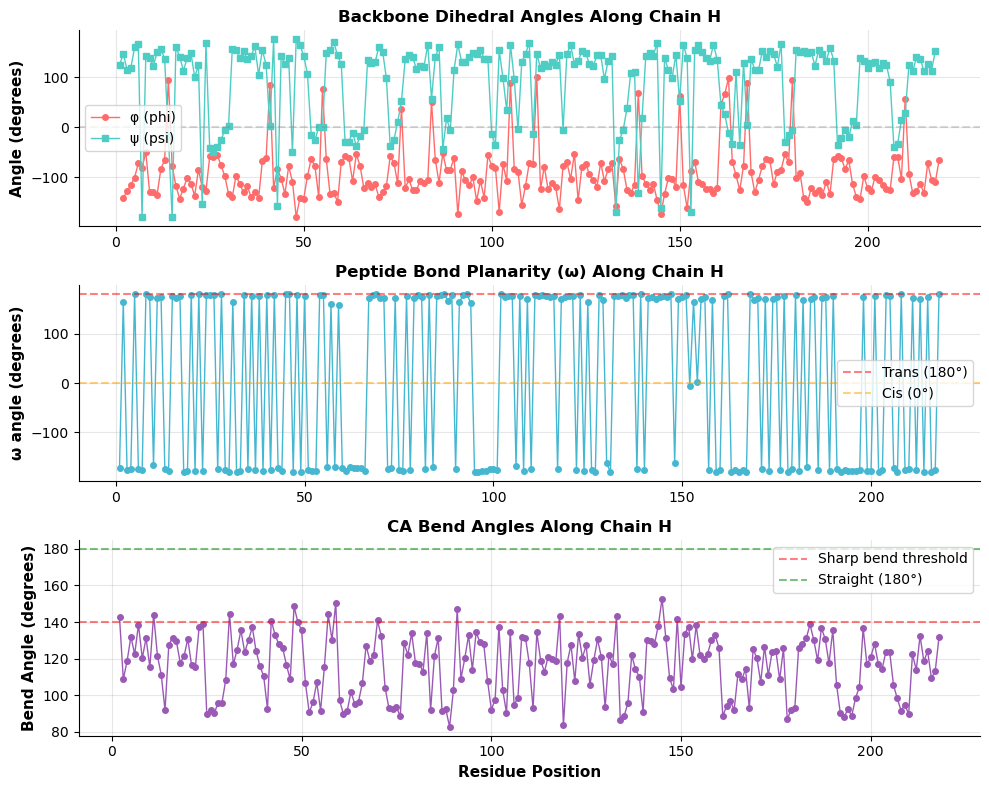

In [26]:
# Plot angles along sequence for chain H
chain_h_backbone = [ba for ba in backbone_angles if ba.chain_id == 'H']
chain_h_bends = [ba for ba in bend_angles if ba.chain_id == 'H']

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot 1: Phi angles
resseqs = [ba.resseq for ba in chain_h_backbone]
phi_vals = [ba.phi if ba.phi is not None else np.nan for ba in chain_h_backbone]
psi_vals = [ba.psi if ba.psi is not None else np.nan for ba in chain_h_backbone]

axes[0].plot(resseqs, phi_vals, 'o-', color='#FF6B6B', markersize=4, linewidth=1, label='φ (phi)')
axes[0].plot(resseqs, psi_vals, 's-', color='#4ECDC4', markersize=4, linewidth=1, label='ψ (psi)')
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Angle (degrees)', fontweight='bold', fontsize=11)
axes[0].set_title('Backbone Dihedral Angles Along Chain H', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Omega angles
omega_vals = [ba.omega if ba.omega is not None else np.nan for ba in chain_h_backbone]
axes[1].plot(resseqs, omega_vals, 'o-', color='#45B7D1', markersize=4, linewidth=1)
axes[1].axhline(180, color='red', linestyle='--', alpha=0.5, label='Trans (180°)')
axes[1].axhline(0, color='orange', linestyle='--', alpha=0.5, label='Cis (0°)')
axes[1].set_ylabel('ω angle (degrees)', fontweight='bold', fontsize=11)
axes[1].set_title('Peptide Bond Planarity (ω) Along Chain H', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 3: Bend angles
bend_resseqs = [ba.resseq_center for ba in chain_h_bends]
bend_vals = [ba.angle_deg if ba.angle_deg is not None else np.nan for ba in chain_h_bends]
axes[2].plot(bend_resseqs, bend_vals, 'o-', color='#9B59B6', markersize=4, linewidth=1)
axes[2].axhline(140, color='red', linestyle='--', alpha=0.5, label='Sharp bend threshold')
axes[2].axhline(180, color='green', linestyle='--', alpha=0.5, label='Straight (180°)')
axes[2].set_xlabel('Residue Position', fontweight='bold', fontsize=11)
axes[2].set_ylabel('Bend Angle (degrees)', fontweight='bold', fontsize=11)
axes[2].set_title('CA Bend Angles Along Chain H', fontweight='bold', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 9. Compare Regions

Compare geometry between different structural regions (e.g., CDRs vs framework).

In [27]:
# Define CDR regions (IMGT numbering)
cdr_ranges = {
    'CDR1': range(26, 33),
    'CDR2': range(52, 57),
    'CDR3': range(95, 103)
}

# Classify residues
cdr_backbone = []
framework_backbone = []

for ba in chain_h_backbone:
    in_cdr = False
    for cdr_name, cdr_range in cdr_ranges.items():
        if ba.resseq in cdr_range:
            in_cdr = True
            break
    
    if in_cdr:
        cdr_backbone.append(ba)
    else:
        framework_backbone.append(ba)

print("=" * 70)
print("CDR vs FRAMEWORK COMPARISON (Chain H)".center(70))
print("=" * 70)

# Compare phi-psi distributions
cdr_phi = [ba.phi for ba in cdr_backbone if ba.phi is not None]
cdr_psi = [ba.psi for ba in cdr_backbone if ba.psi is not None]
fw_phi = [ba.phi for ba in framework_backbone if ba.phi is not None]
fw_psi = [ba.psi for ba in framework_backbone if ba.psi is not None]

print(f"{'Region':<15}{'Residues':<12}{'φ mean':<12}{'ψ mean':<12}{'φ std':<12}{'ψ std':<12}")
print("-" * 70)
print(f"{'CDR':<15}{len(cdr_backbone):<12}{np.mean(cdr_phi):<12.1f}{np.mean(cdr_psi):<12.1f}"
      f"{np.std(cdr_phi):<12.1f}{np.std(cdr_psi):<12.1f}")
print(f"{'Framework':<15}{len(framework_backbone):<12}{np.mean(fw_phi):<12.1f}{np.mean(fw_psi):<12.1f}"
      f"{np.std(fw_phi):<12.1f}{np.std(fw_psi):<12.1f}")
print("=" * 70)

                CDR vs FRAMEWORK COMPARISON (Chain H)                 
Region         Residues    φ mean      ψ mean      φ std       ψ std       
----------------------------------------------------------------------
CDR            20          -90.1       56.8        51.3        84.5        
Framework      199         -92.4       92.2        54.0        82.5        


### Ramachandran Plot: CDR vs Framework

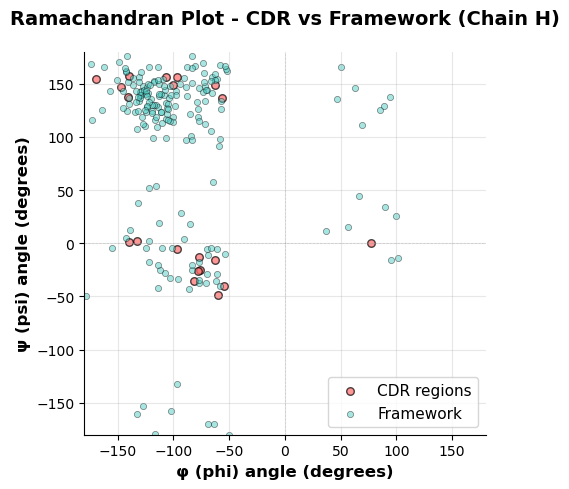


Observation: CDR regions often show more diverse φ-ψ angles due to loop flexibility.


In [31]:
# Compare Ramachandran plots
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(cdr_phi, cdr_psi, c='#FF6B6B', s=30, alpha=0.7, 
          edgecolors='black', linewidth=1, label='CDR regions')
ax.scatter(fw_phi, fw_psi, c='#4ECDC4', s=20, alpha=0.5,
          edgecolors='black', linewidth=0.5, label='Framework')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

ax.set_xlabel('φ (phi) angle (degrees)', fontweight='bold', fontsize=12)
ax.set_ylabel('ψ (psi) angle (degrees)', fontweight='bold', fontsize=12)
ax.set_title('Ramachandran Plot - CDR vs Framework (Chain H)', 
             fontweight='bold', fontsize=14, pad=20)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nObservation: CDR regions often show more diverse φ-ψ angles due to loop flexibility.")

## 10. Key Findings Summary

In [32]:
print("=" * 80)
print("KEY FINDINGS: GEOMETRY ANALYSIS SUMMARY".center(80))
print("=" * 80)

print("\n📐 Backbone Dihedrals (φ, ψ, ω):")
valid_phi_psi = len([ba for ba in backbone_angles if ba.phi is not None and ba.psi is not None])
print(f"   • Total residues analyzed: {len(backbone_angles)}")
print(f"   • Valid φ-ψ pairs: {valid_phi_psi}")
print(f"   • Cis peptide bonds: {len(cis_peptides)}")
print(f"   • Omega angle mean: {np.mean(omega_vals):.1f}° (trans peptides)")

print("\n🔄 Sidechain Rotamers (χ angles):")
print(f"   • Residues with chi angles: {len(sidechain_chis)}")
for num_chis, count in sorted(chi_counts.items()):
    print(f"   • χ1-χ{num_chis}: {count} residues")

print("\n📏 Backbone Curvature:")
print(f"   • Mean bend angle: {np.mean(angles):.1f}°")
print(f"   • Sharp bends (< 140°): {len(sharp_bends)}")
if sharp_bends:
    sharpest = min(sharp_bends, key=lambda x: x.angle_deg)
    print(f"   • Sharpest bend: {sharpest.residue_id} ({sharpest.angle_deg:.1f}°)")

print("\n🎯 Region Comparison (Chain H):")
print(f"   • CDR residues: {len(cdr_backbone)}")
print(f"   • Framework residues: {len(framework_backbone)}")
print(f"   • CDR φ variability (std): {np.std(cdr_phi):.1f}°")
print(f"   • Framework φ variability (std): {np.std(fw_phi):.1f}°")

print("\n" + "=" * 80)

                    KEY FINDINGS: GEOMETRY ANALYSIS SUMMARY                     

📐 Backbone Dihedrals (φ, ψ, ω):
   • Total residues analyzed: 549
   • Valid φ-ψ pairs: 543
   • Cis peptide bonds: 9
   • Omega angle mean: nan° (trans peptides)

🔄 Sidechain Rotamers (χ angles):
   • Residues with chi angles: 474
   • χ1-χ1: 175 residues
   • χ1-χ2: 193 residues
   • χ1-χ3: 54 residues
   • χ1-χ4: 52 residues

📏 Backbone Curvature:
   • Mean bend angle: 116.3°
   • Sharp bends (< 140°): 512
   • Sharpest bend: GLU A:31 (72.4°)

🎯 Region Comparison (Chain H):
   • CDR residues: 20
   • Framework residues: 199
   • CDR φ variability (std): 51.3°
   • Framework φ variability (std): 54.0°



## END 